In [49]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')



In [50]:

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train['fecha'] = pd.to_datetime(df_train['fecha'])
df_train = df_train.set_index('fecha')
df_test['fecha'] = pd.to_datetime(df_test['fecha'])
df_test = df_test.set_index('fecha')

print("\n--- Información de df_train ---")
print(df_train.info())

# Seleccion subestación 'AJAHUEL' para el análisis y modelado
subestacion_id = 'AJAHUEL'
df_train_sub = df_train[df_train['subestacion'] == subestacion_id].copy()
df_test_sub = df_test[df_test['subestacion'] == subestacion_id].copy()

data_train = df_train_sub['consumo']
data_test = df_test_sub['consumo']


--- Información de df_train ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244391 entries, 2018-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   subestacion  244391 non-null  object 
 1   consumo      244391 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.6+ MB
None


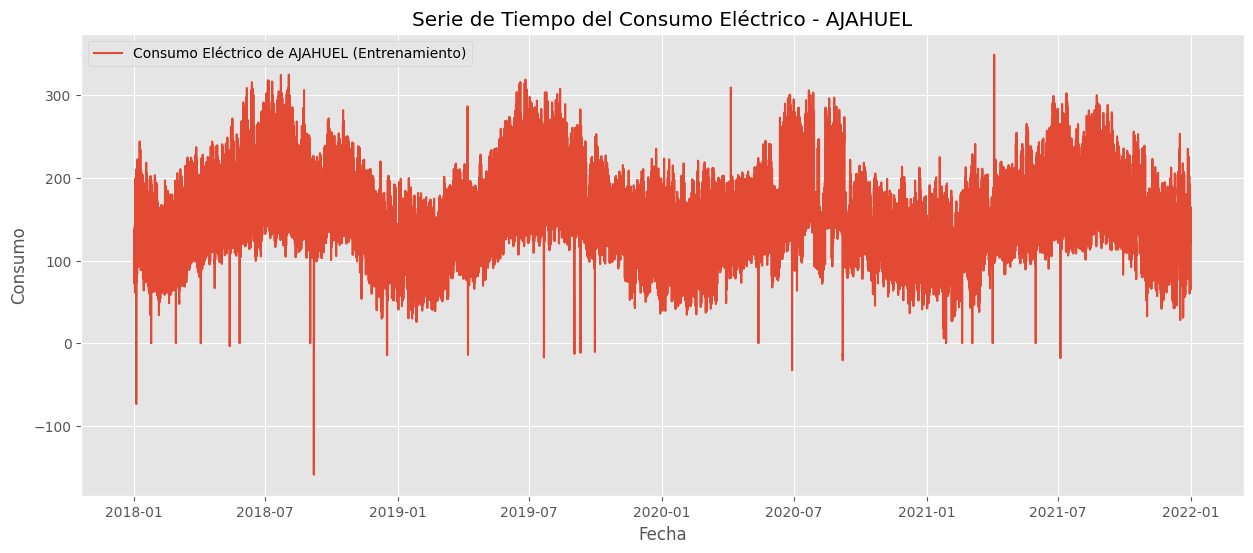

In [51]:
#Gráfico de la Serie de Tiempo
plt.figure(figsize=(15, 6))
plt.plot(data_train, label='Consumo Eléctrico de AJAHUEL (Entrenamiento)')
plt.title(f'Serie de Tiempo del Consumo Eléctrico - {subestacion_id}')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show() #

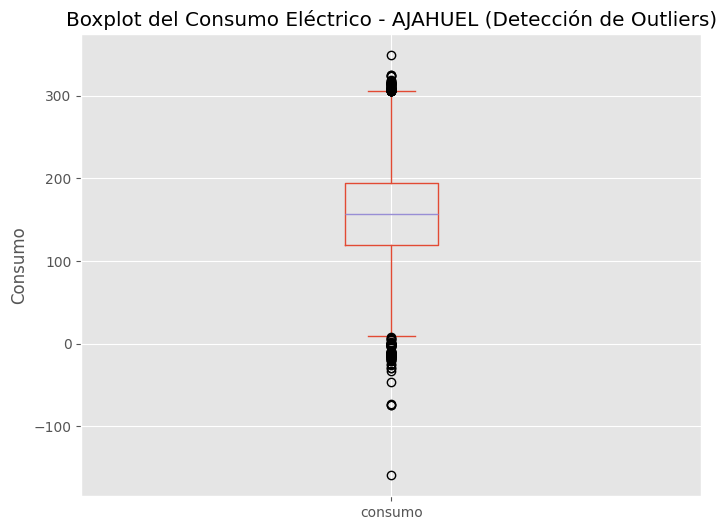

In [52]:
# Gráfico Boxplot para Outliers en el consumo
plt.figure(figsize=(8, 6))
data_train.plot(kind='box')
plt.title(f'Boxplot del Consumo Eléctrico - {subestacion_id} (Detección de Outliers)')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()

<Figure size 1500x1000 with 0 Axes>

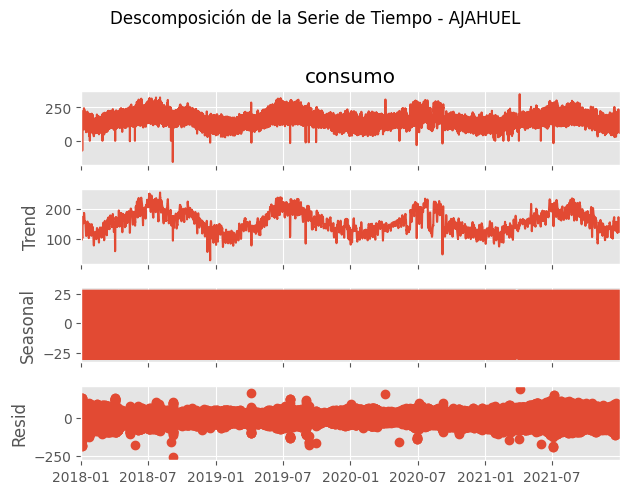

In [53]:
# Gráfico de Variaciones (Descomposición de la Serie de Tiempo)

decomposition = seasonal_decompose(data_train, model='additive', period=24)

plt.figure(figsize=(15, 10))
decomposition.plot()
plt.suptitle(f'Descomposición de la Serie de Tiempo - {subestacion_id}', y=1.02)
plt.tight_layout()
plt.show()

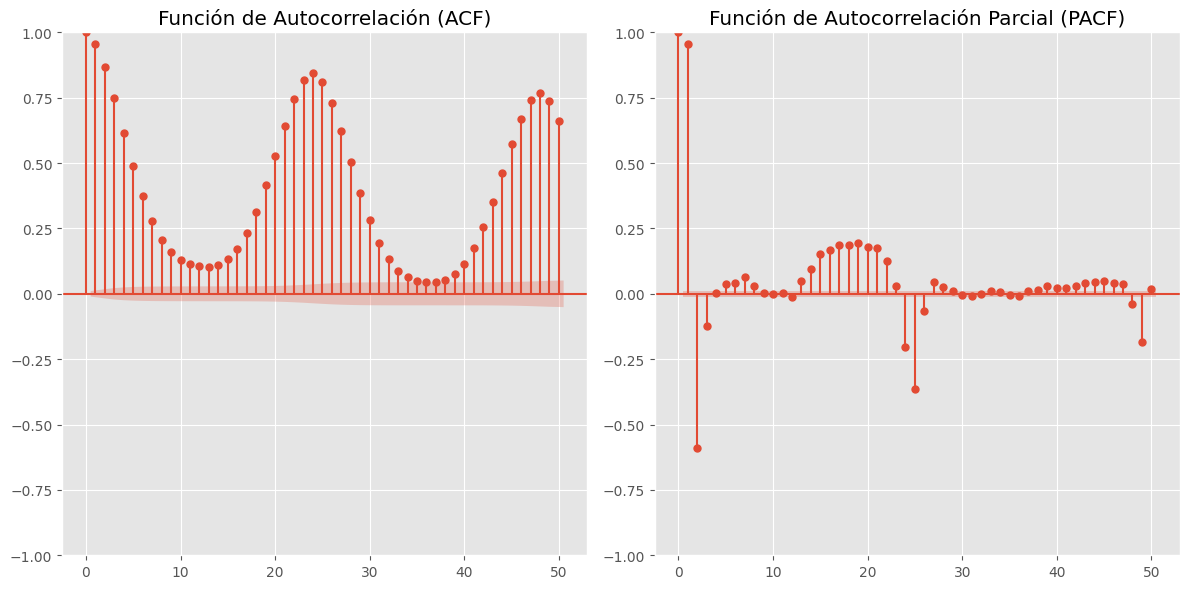

In [54]:
# Autocorrelación y Correlaciones Parciales
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
plot_acf(data_train, lags=50, ax=ax1, title='Función de Autocorrelación (ACF)')

ax2 = plt.subplot(122)
plot_pacf(data_train, lags=50, ax=ax2, title='Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

In [55]:
# Preprocesamiento de Datos para RNNs

# 1. Normalización de Datos
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(data_train.values.reshape(-1, 1))
test_scaled = scaler.transform(data_test.values.reshape(-1, 1))

# 2. Función para crear conjuntos de datos con ventanas de tiempo
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        # Secuencia pasada (X)
        X.append(data[i:(i + time_step), 0])
        # Valor futuro (Y)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Definir el tamaño de la ventana de tiempo (24 horas previas)
time_step = 24

# Crear los datasets de entrenamiento y prueba
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# 3. Reshape de los datos para que Keras los acepte (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Forma de X_train (RNN): {X_train.shape}")
print(f"Forma de X_test (RNN): {X_test.shape}")

Forma de X_train (RNN): (34889, 24, 1)
Forma de X_test (RNN): (8735, 24, 1)


In [56]:
# Entrenamiento y Predicción con Modelo Sequential (Dense)

model_sequential = Sequential([
    Dense(50, activation='relu', input_shape=(time_step, 1)),
    Dense(1)
])

model_sequential.compile(optimizer='adam', loss='mean_squared_error')
print("Entrenando Modelo Sequential (Dense)...")
history_sequential = model_sequential.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=64,
    verbose=0
)

predictions_sequential_scaled = model_sequential.predict(X_test)

N = X_test.shape[0]
predictions_sequential_scaled_reshaped = predictions_sequential_scaled.reshape(N, -1)[:, 0].reshape(-1, 1)


predictions_sequential = scaler.inverse_transform(predictions_sequential_scaled_reshaped)

y_test_sequential = data_test.values[time_step:]
y_pred_sequential = predictions_sequential.flatten()
print(f"Modelo Sequential entrenado. Longitud de y_pred_sequential: {len(y_pred_sequential)}")

Entrenando Modelo Sequential (Dense)...
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Modelo Sequential entrenado. Longitud de y_pred_sequential: 8735


In [57]:
# Entrenamiento y Predicción con Modelo GRU

model_gru = Sequential([
    GRU(50, return_sequences=False, input_shape=(time_step, 1)),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
print("Entrenando Modelo GRU...")
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=64,
    verbose=0
)

predictions_gru_scaled = model_gru.predict(X_test)

N = X_test.shape[0]
predictions_gru_scaled_reshaped = predictions_gru_scaled.reshape(N, -1)[:, 0].reshape(-1, 1)

predictions_gru = scaler.inverse_transform(predictions_gru_scaled_reshaped)

y_test_gru = data_test.values[time_step:]
y_pred_gru = predictions_gru.flatten()
print(f"Modelo GRU entrenado. Longitud de y_pred_gru: {len(y_pred_gru)}")

Entrenando Modelo GRU...
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Modelo GRU entrenado. Longitud de y_pred_gru: 8735


In [58]:
# Entrenamiento y Predicción con Modelo LSTM

model_lstm = Sequential([
    LSTM(50, return_sequences=False, input_shape=(time_step, 1)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
print("Entrenando Modelo LSTM...")
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=64,
    verbose=0
)

predictions_lstm_scaled = model_lstm.predict(X_test)

N = X_test.shape[0]
predictions_lstm_scaled_reshaped = predictions_lstm_scaled.reshape(N, -1)[:, 0].reshape(-1, 1)

predictions_lstm = scaler.inverse_transform(predictions_lstm_scaled_reshaped)

y_test_lstm = data_test.values[time_step:]
y_pred_lstm = predictions_lstm.flatten()
print(f"Modelo LSTM entrenado. Longitud de y_pred_lstm: {len(y_pred_lstm)}")

Entrenando Modelo LSTM...
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Modelo LSTM entrenado. Longitud de y_pred_lstm: 8735


In [59]:
# Cálculo de Métricas y Comparación

def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'Modelo': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

metrics_sequential = calculate_metrics(y_test_sequential, y_pred_sequential, 'Sequential (Dense)')
metrics_gru = calculate_metrics(y_test_gru, y_pred_gru, 'GRU')
metrics_lstm = calculate_metrics(y_test_lstm, y_pred_lstm, 'LSTM')

comparison_df = pd.DataFrame([metrics_sequential, metrics_gru, metrics_lstm])
comparison_df = comparison_df.sort_values(by='RMSE')

print("\n--- Comparación de Métricas de Modelos RNN/DL de Consumo Eléctrico ---")
print(comparison_df.to_string(index=False))



--- Comparación de Métricas de Modelos RNN/DL de Consumo Eléctrico ---
            Modelo       RMSE       MAE        R2
              LSTM  18.083338 10.095853  0.962793
               GRU  18.780451  9.368908  0.959869
Sequential (Dense) 102.807955 76.022563 -0.202593


In [60]:
#Gráficos de Predicciones

test_index_rnn = data_test.index[time_step:]
y_real = y_test_gru 

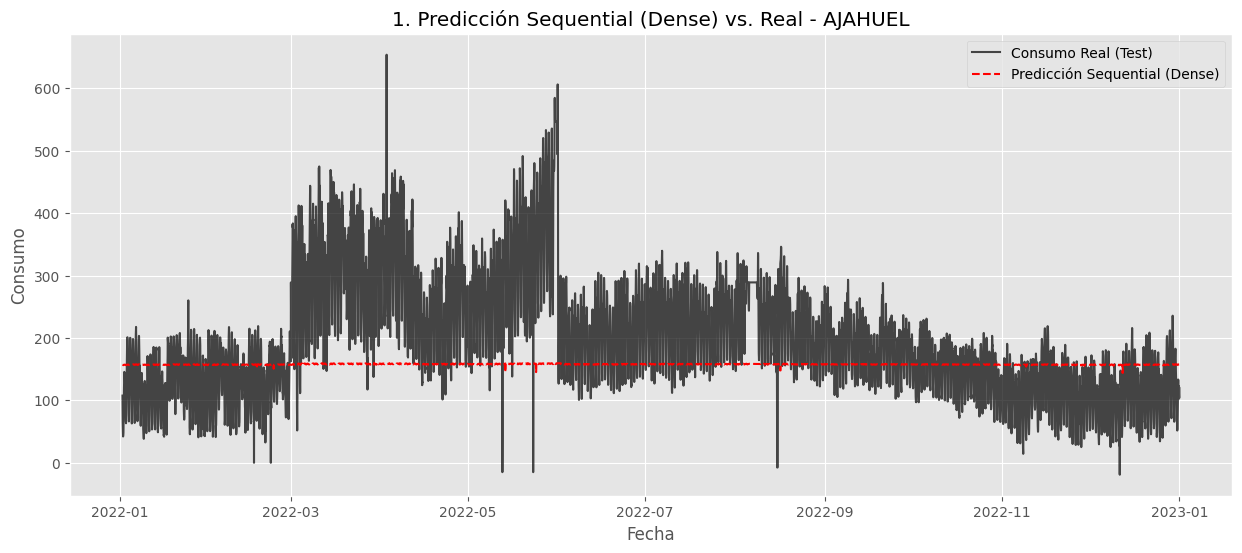

In [61]:
# --- GRÁFICO 1: REAL vs. SEQUENTIAL (DENSE) ---
plt.figure(figsize=(15, 6))
plt.plot(test_index_rnn, y_real, label='Consumo Real (Test)', color='black', alpha=0.7)
plt.plot(test_index_rnn, y_pred_sequential, label='Predicción Sequential (Dense)', color='red', linestyle='--')
plt.title(f'1. Predicción Sequential (Dense) vs. Real - {subestacion_id}')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

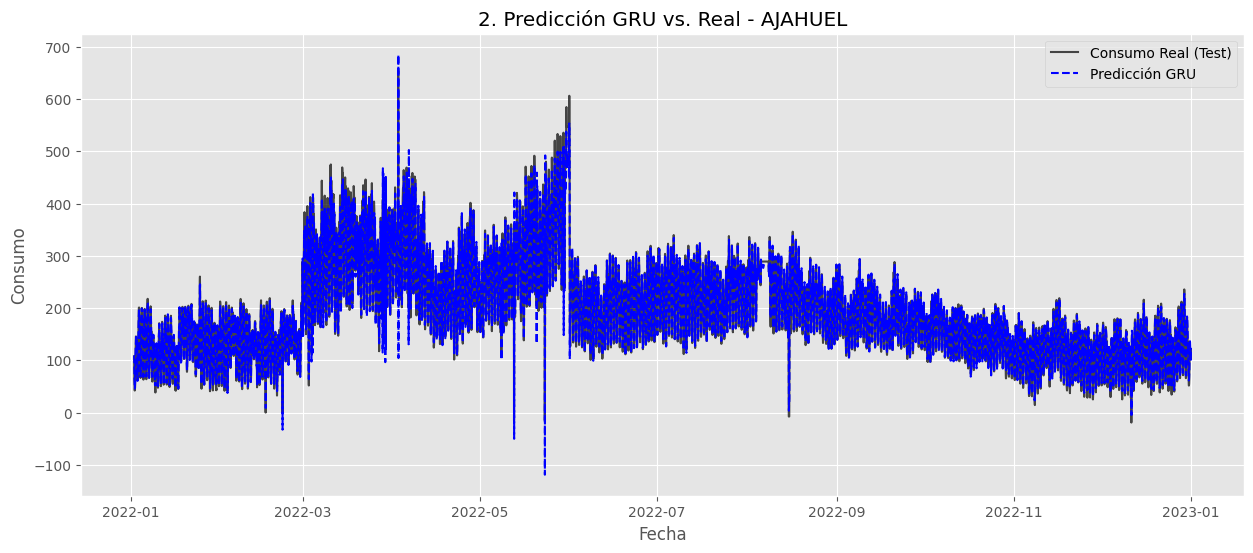

In [62]:
# --- GRÁFICO 2: REAL vs. GRU ---
plt.figure(figsize=(15, 6))
plt.plot(test_index_rnn, y_real, label='Consumo Real (Test)', color='black', alpha=0.7)
plt.plot(test_index_rnn, y_pred_gru, label='Predicción GRU', color='blue', linestyle='--')
plt.title(f'2. Predicción GRU vs. Real - {subestacion_id}')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

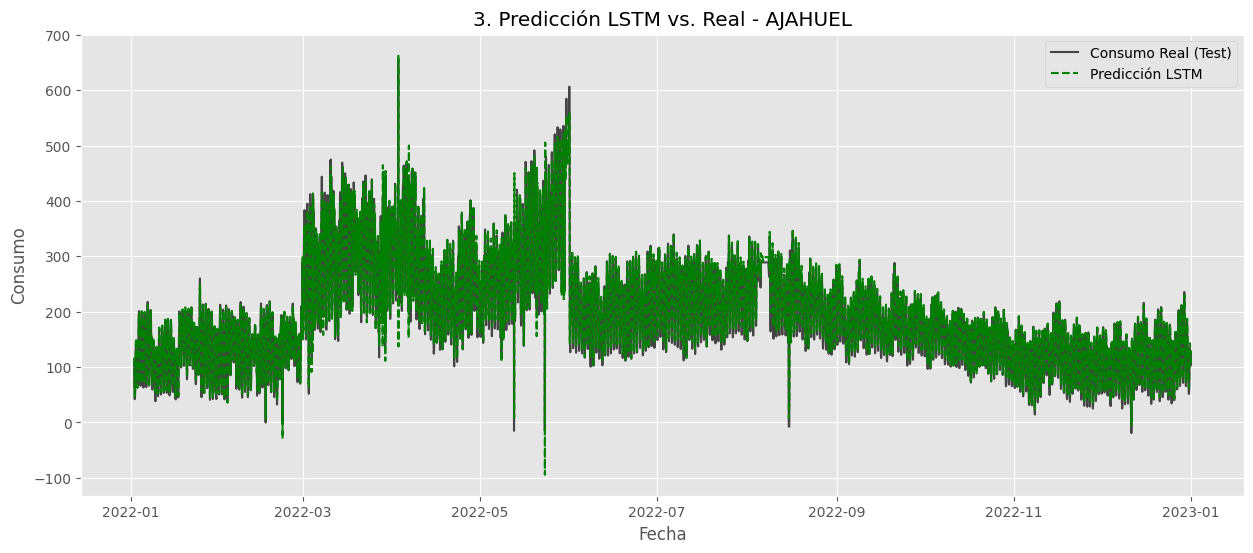

In [63]:
# --- GRÁFICO 3: REAL vs. LSTM ---
plt.figure(figsize=(15, 6))
plt.plot(test_index_rnn, y_real, label='Consumo Real (Test)', color='black', alpha=0.7)
plt.plot(test_index_rnn, y_pred_lstm, label='Predicción LSTM', color='green', linestyle='--')
plt.title(f'3. Predicción LSTM vs. Real - {subestacion_id}')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
# Entrenamiento y Predicción con Modelo GRU v2.0

from tensorflow.keras.layers import Dropout

# Definición del Modelo GRU v2.0:
# 1. Arquitectura de dos capas GRU (75 unidades por capa).
# 2. Dropout (0.2) en la primera capa para regularización.
# 3. Mayor número de épocas (50).

model_gru_v2 = Sequential([
    GRU(75, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2), 
    GRU(75, return_sequences=False),
    Dense(1)
])

model_gru_v2.compile(optimizer='adam', loss='mean_squared_error')
print("--- Entrenando Modelo GRU v2.0 ---")
history_gru_v2 = model_gru_v2.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=64,
    verbose=0
)

predictions_gru_v2_scaled = model_gru_v2.predict(X_test)

N = X_test.shape[0]
predictions_gru_v2_scaled_reshaped = predictions_gru_v2_scaled.reshape(N, -1)[:, 0].reshape(-1, 1)

predictions_gru_v2 = scaler.inverse_transform(predictions_gru_v2_scaled_reshaped)

y_test_gru_v2 = data_test.values[time_step:]
y_pred_gru_v2 = predictions_gru_v2.flatten()
print("Modelo GRU v2.0 entrenado.")
print(f"Longitud de y_pred_gru_v2: {len(y_pred_gru_v2)}")

--- Entrenando Modelo GRU v2.0 ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Modelo GRU v2.0 entrenado.
Longitud de y_pred_gru_v2: 8735


In [65]:
# Comparación de Métricas v2.0 (GRU Original vs. GRU Optimizado)

metrics_gru_original = calculate_metrics(y_test_gru, y_pred_gru, 'GRU Original')

metrics_gru_v2 = calculate_metrics(y_test_gru_v2, y_pred_gru_v2, 'GRU v2.0 Optimizado')

metrics_lstm = calculate_metrics(y_test_lstm, y_pred_lstm, 'LSTM') 

comparison_df_v2 = pd.DataFrame([metrics_gru_original, metrics_lstm, metrics_gru_v2])
comparison_df_v2 = comparison_df_v2.sort_values(by='RMSE')

print("\n--- Comparación de la Evolución de Modelos (GRU vs. GRU v2.0) ---")
print(comparison_df_v2.to_string(index=False))


--- Comparación de la Evolución de Modelos (GRU vs. GRU v2.0) ---
             Modelo      RMSE       MAE       R2
               LSTM 18.083338 10.095853 0.962793
       GRU Original 18.780451  9.368908 0.959869
GRU v2.0 Optimizado 22.684669 11.403991 0.941450


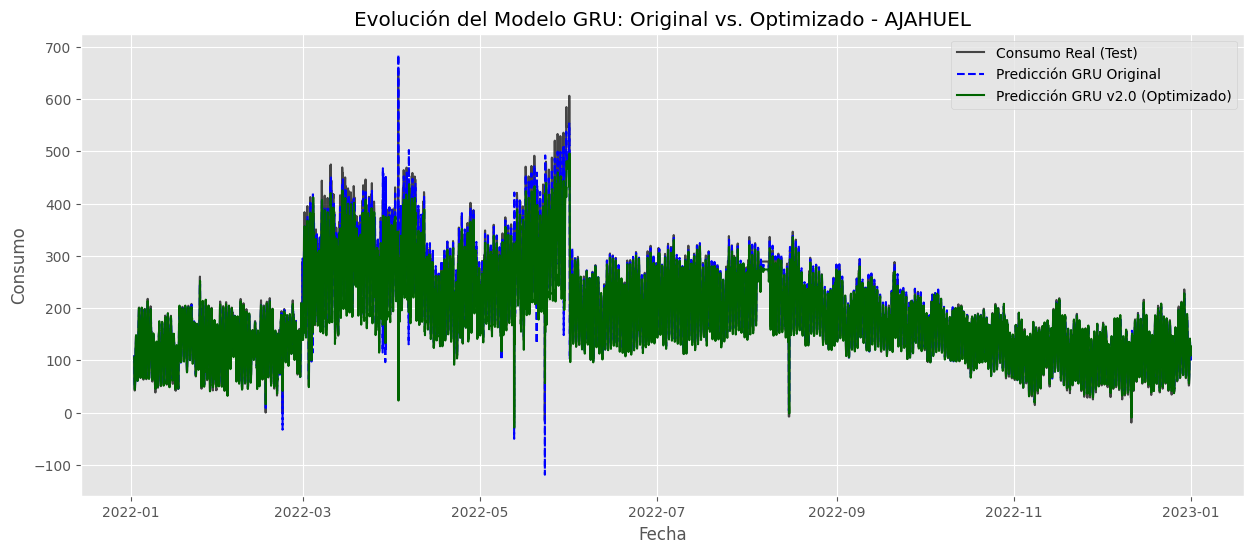

In [66]:
# Gráfico de Comparación del Rendimiento GRU (Original vs. Optimizado)

test_index_rnn = data_test.index[time_step:]
y_real = y_test_gru

plt.figure(figsize=(15, 6))

plt.plot(test_index_rnn, y_real, label='Consumo Real (Test)', color='black', alpha=0.7)
plt.plot(test_index_rnn, y_pred_gru, label='Predicción GRU Original', color='blue', linestyle='--')
plt.plot(test_index_rnn, y_pred_gru_v2, label='Predicción GRU v2.0 (Optimizado)', color='darkgreen', linestyle='-')

plt.title(f'Evolución del Modelo GRU: Original vs. Optimizado - {subestacion_id}')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Entrenamiento y Predicción con Modelo LSTM v2.0 (Optimizado)

from tensorflow.keras.layers import Dropout

# Definición del Modelo LSTM v2.0:
# 1. Arquitectura de dos capas LSTM (75 unidades por capa).
# 2. Dropout (0.2) en la primera capa para regularización.
# 3. Mayor número de épocas (50).

model_lstm_v2 = Sequential([

    LSTM(75, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2), 
    
    LSTM(75, return_sequences=False),
    Dense(1)
])

model_lstm_v2.compile(optimizer='adam', loss='mean_squared_error')
print("--- Entrenando Modelo LSTM v2.0 (Optimizado) (usando GPU) ---")
history_lstm_v2 = model_lstm_v2.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=64,
    verbose=0
)

predictions_lstm_v2_scaled = model_lstm_v2.predict(X_test)

N = X_test.shape[0]
predictions_lstm_v2_scaled_reshaped = predictions_lstm_v2_scaled.reshape(N, -1)[:, 0].reshape(-1, 1)

predictions_lstm_v2 = scaler.inverse_transform(predictions_lstm_v2_scaled_reshaped)

y_test_lstm_v2 = data_test.values[time_step:]
y_pred_lstm_v2 = predictions_lstm_v2.flatten()
print("Modelo LSTM v2.0 entrenado.")
print(f"Longitud de y_pred_lstm_v2: {len(y_pred_lstm_v2)}")

--- Entrenando Modelo LSTM v2.0 (Optimizado) (usando GPU) ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Modelo LSTM v2.0 entrenado.
Longitud de y_pred_lstm_v2: 8735


In [68]:
# Comparación de Métricas v2.0 (GRU, LSTM Original, y LSTM v2.0)


metrics_lstm_original = calculate_metrics(y_test_lstm, y_pred_lstm, 'LSTM Original')

metrics_gru_original = calculate_metrics(y_test_gru, y_pred_gru, 'GRU Original')

metrics_lstm_v2 = calculate_metrics(y_test_lstm_v2, y_pred_lstm_v2, 'LSTM v2.0 Optimizado')

comparison_df_v3 = pd.DataFrame([metrics_lstm_original, metrics_gru_original, metrics_lstm_v2])
comparison_df_v3 = comparison_df_v3.sort_values(by='RMSE')

print("\n--- Comparación Final de Modelos Líderes (LSTM vs. GRU vs. LSTM v2.0) ---")
print(comparison_df_v3.to_string(index=False))


--- Comparación Final de Modelos Líderes (LSTM vs. GRU vs. LSTM v2.0) ---
              Modelo      RMSE       MAE       R2
       LSTM Original 18.083338 10.095853 0.962793
        GRU Original 18.780451  9.368908 0.959869
LSTM v2.0 Optimizado 18.984829  8.905221 0.958991


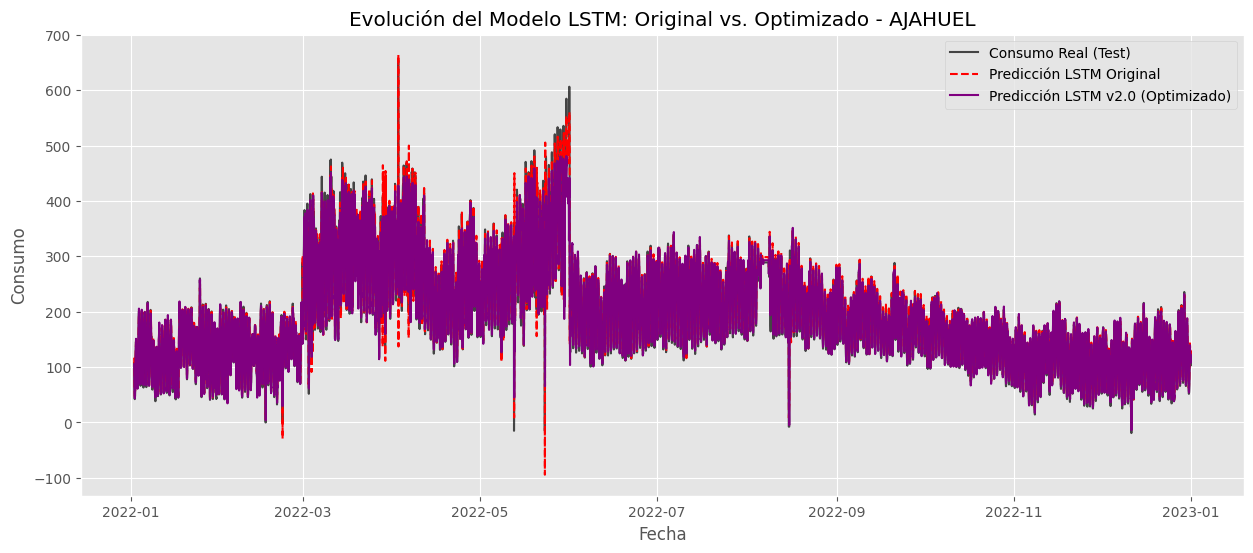

In [69]:
# Gráfico de Comparación del Rendimiento LSTM (Original vs. Optimizado)

test_index_rnn = data_test.index[time_step:]
y_real = y_test_lstm 

plt.figure(figsize=(15, 6))

plt.plot(test_index_rnn, y_real, label='Consumo Real (Test)', color='black', alpha=0.7)
plt.plot(test_index_rnn, y_pred_lstm, label='Predicción LSTM Original', color='red', linestyle='--')
plt.plot(test_index_rnn, y_pred_lstm_v2, label='Predicción LSTM v2.0 (Optimizado)', color='purple', linestyle='-')

plt.title(f'Evolución del Modelo LSTM: Original vs. Optimizado - {subestacion_id}')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Carga de Datos Global e Identificación de Subestaciones


# Cargar los datasets (asumiendo que ya están en el directorio de trabajo en VS Code)
try:
    df_train_full = pd.read_csv('train.csv')
    df_test_full = pd.read_csv('test.csv')
except FileNotFoundError:
    print("Error: Asegúrate de que los archivos 'train.csv' y 'test.csv' estén en el directorio de trabajo.")
    raise

# Conversión a datetime y establecimiento de índice
df_train_full['fecha'] = pd.to_datetime(df_train_full['fecha'])
df_train_full = df_train_full.set_index('fecha').sort_index()
df_test_full['fecha'] = pd.to_datetime(df_test_full['fecha'])
df_test_full = df_test_full.set_index('fecha').sort_index()

In [71]:
# Identificar todas las subestaciones únicas
subestaciones = df_train_full['subestacion'].unique()
print(f"Subestaciones identificadas (Total: {len(subestaciones)}):")
print(subestaciones)

Subestaciones identificadas (Total: 7):
['AJAHUEL' 'FLORIDA' 'CHENA' 'CNAVIA' 'ELSALTO' 'BUIN' 'LOSALME']


In [72]:
NUM_SUBESTACIONES_A_ANALIZAR = 7

if NUM_SUBESTACIONES_A_ANALIZAR is not None:
    subestaciones_analisis = subestaciones[:NUM_SUBESTACIONES_A_ANALIZAR]
    print(f"\nGenerando gráficos de análisis solo para las primeras {NUM_SUBESTACIONES_A_ANALIZAR} subestaciones.")
else:
    subestaciones_analisis = subestaciones
    print("\nGenerando gráficos de análisis para TODAS las subestaciones.")


Generando gráficos de análisis solo para las primeras 7 subestaciones.



--- Analizando Subestación: AJAHUEL ---


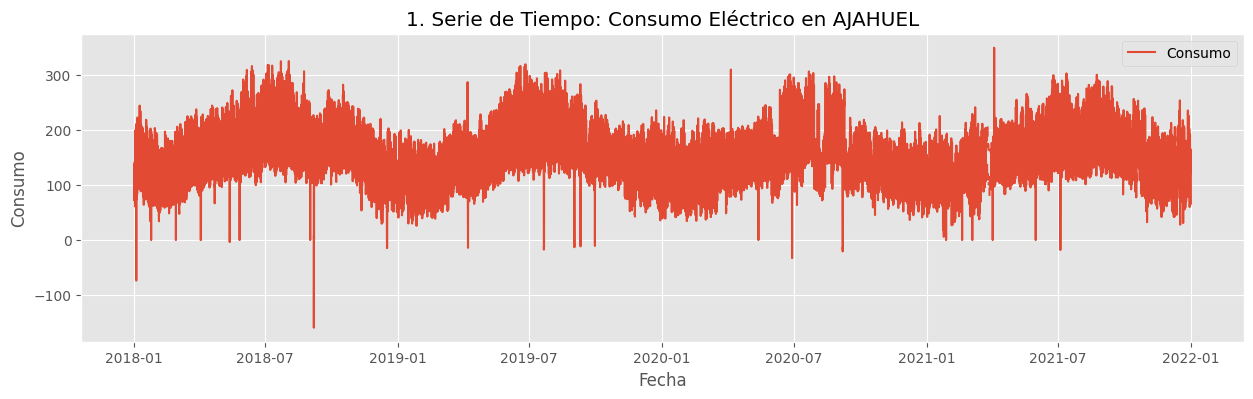

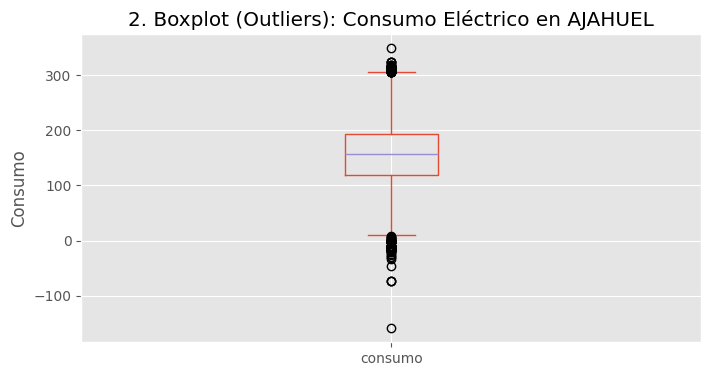

<Figure size 1500x800 with 0 Axes>

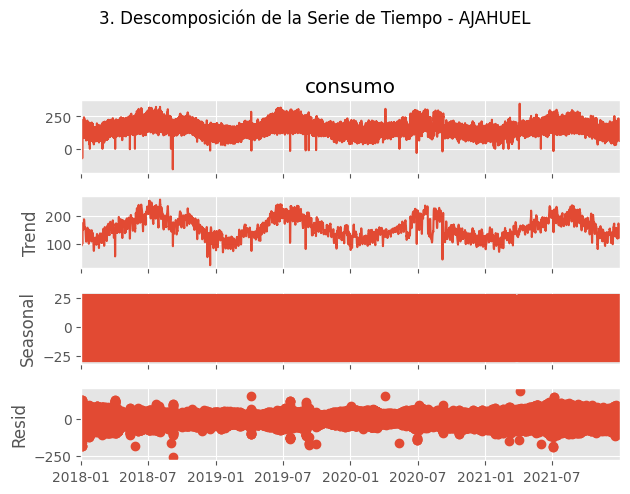

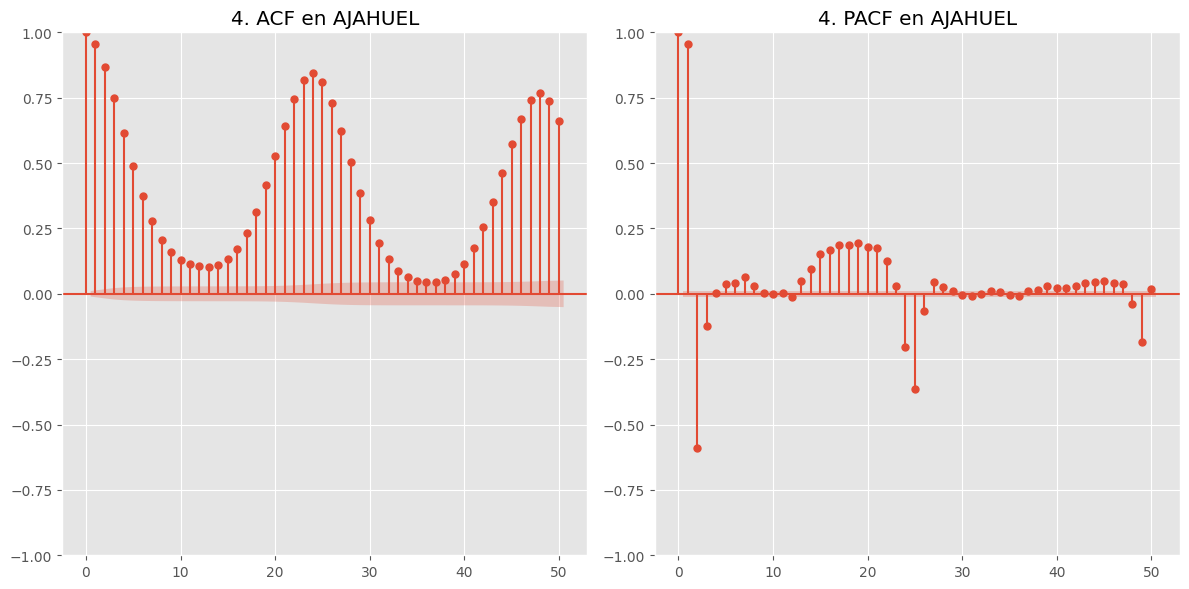


--- Analizando Subestación: FLORIDA ---


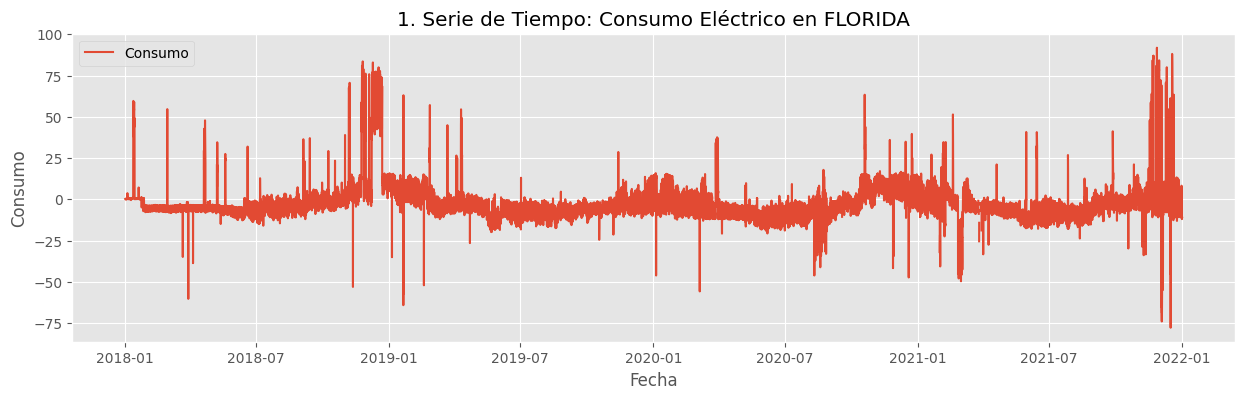

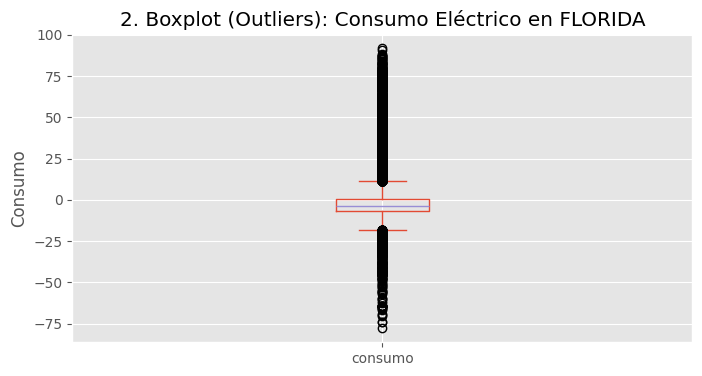

<Figure size 1500x800 with 0 Axes>

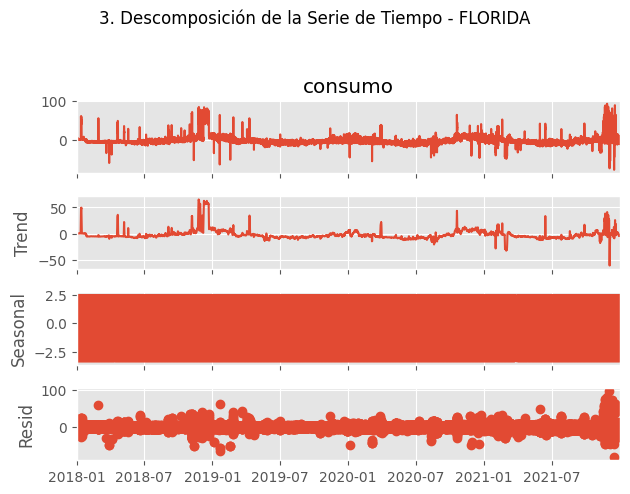

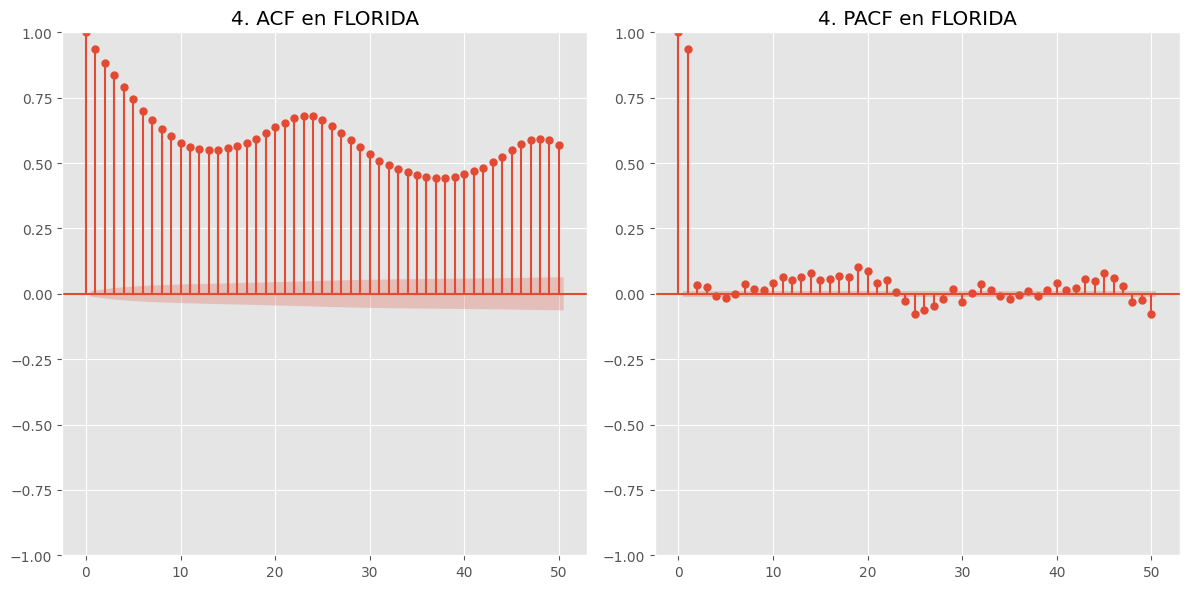


--- Analizando Subestación: CHENA ---


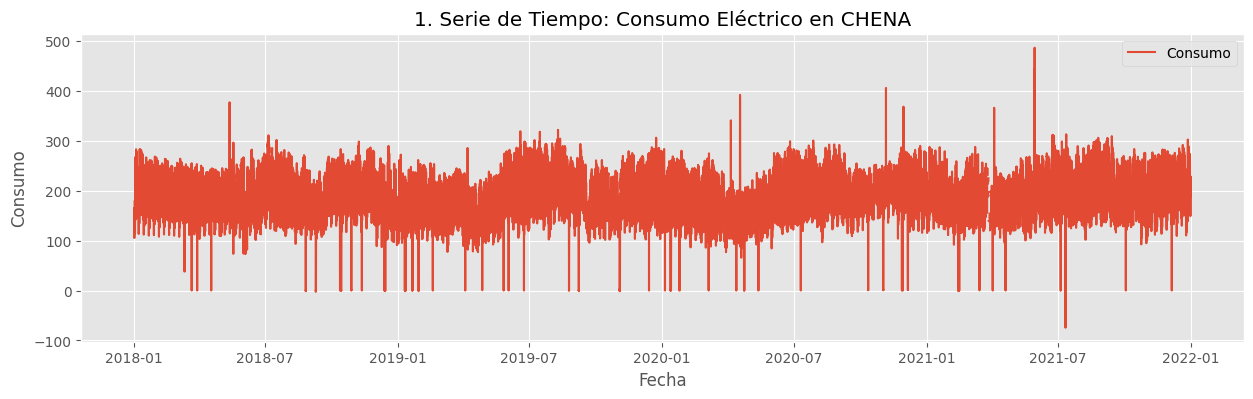

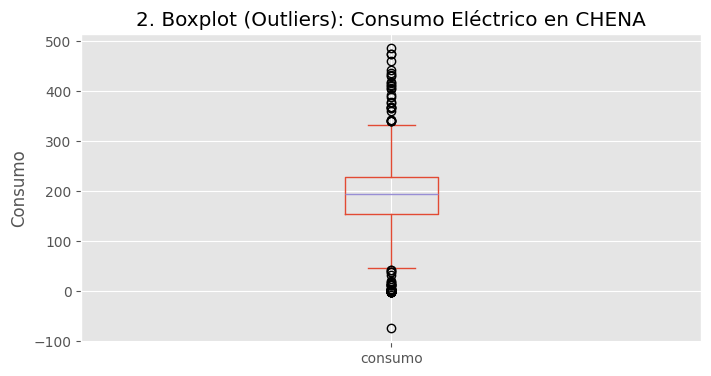

<Figure size 1500x800 with 0 Axes>

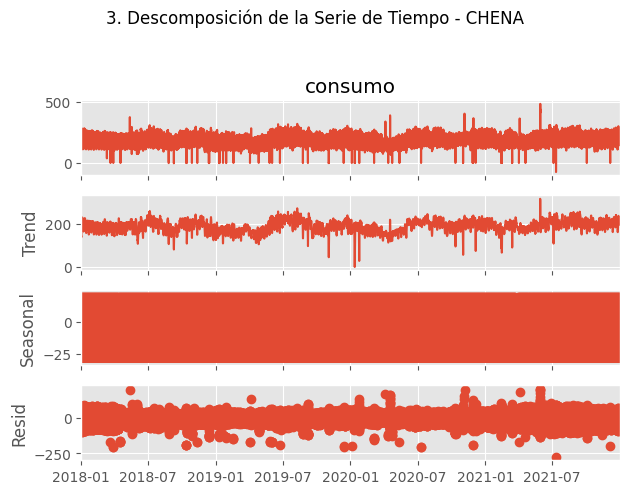

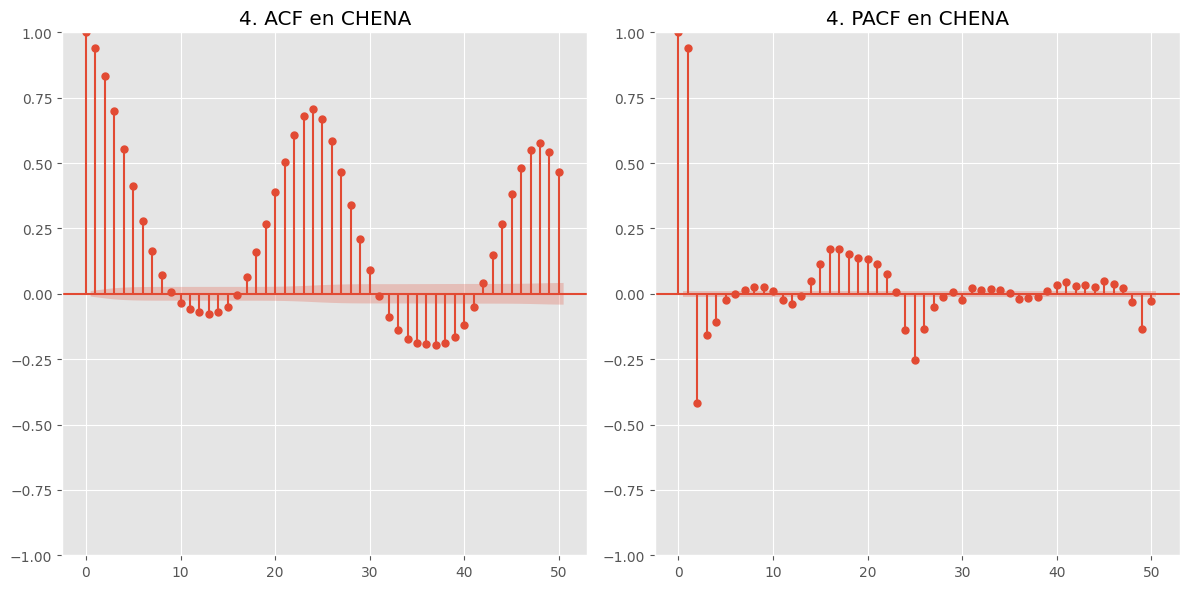


--- Analizando Subestación: CNAVIA ---


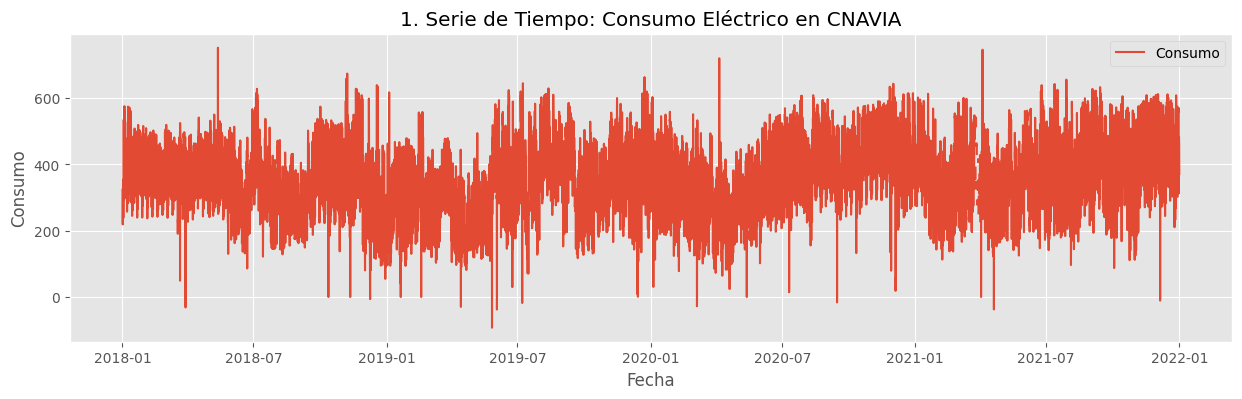

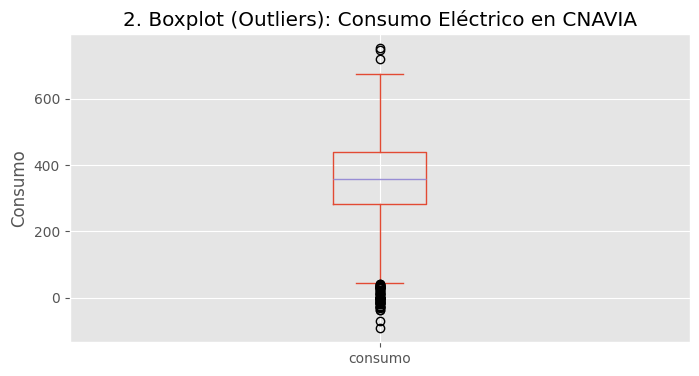

<Figure size 1500x800 with 0 Axes>

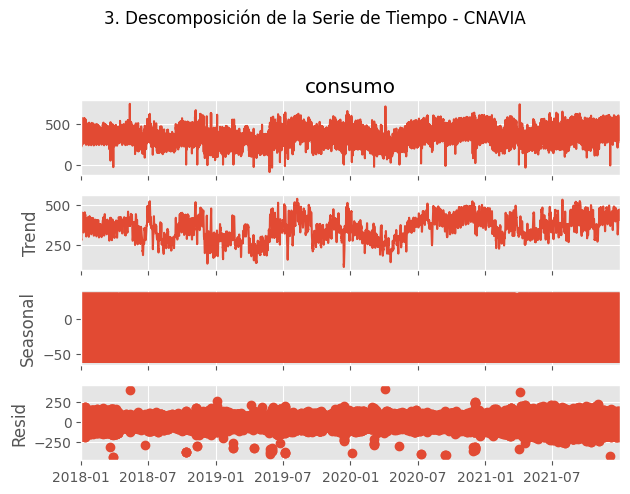

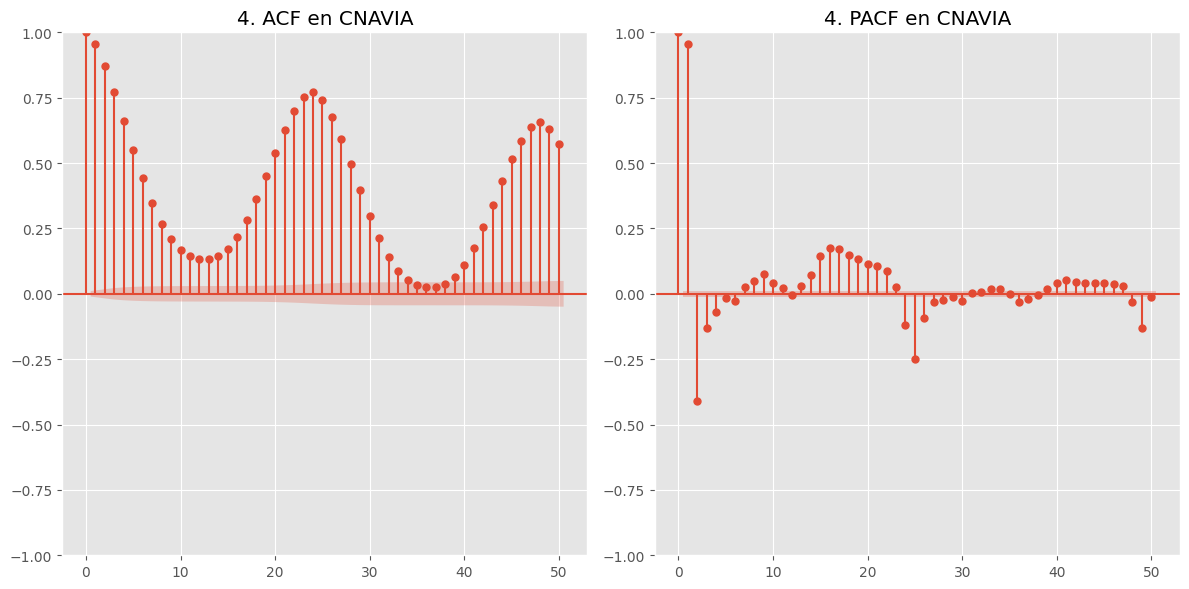


--- Analizando Subestación: ELSALTO ---


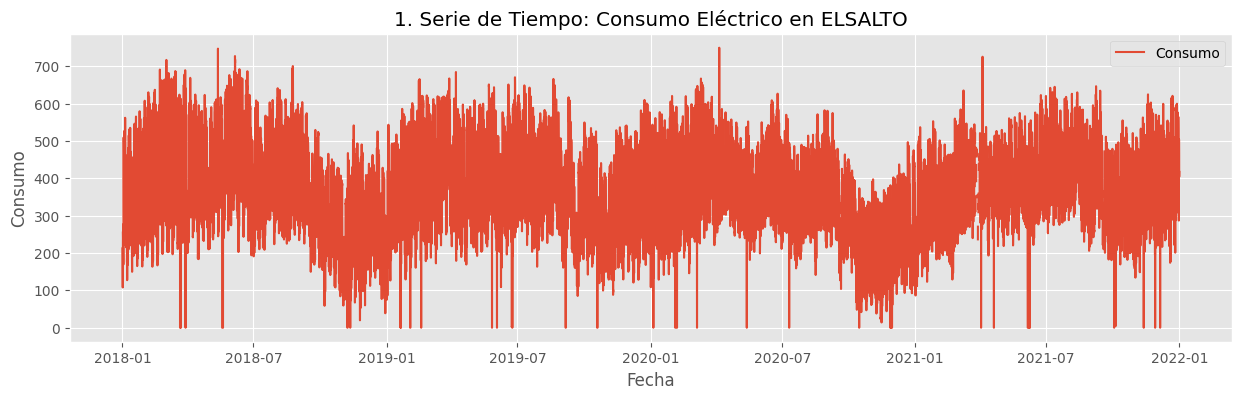

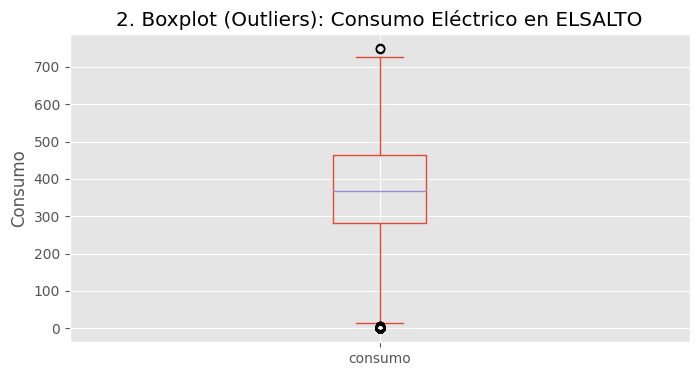

<Figure size 1500x800 with 0 Axes>

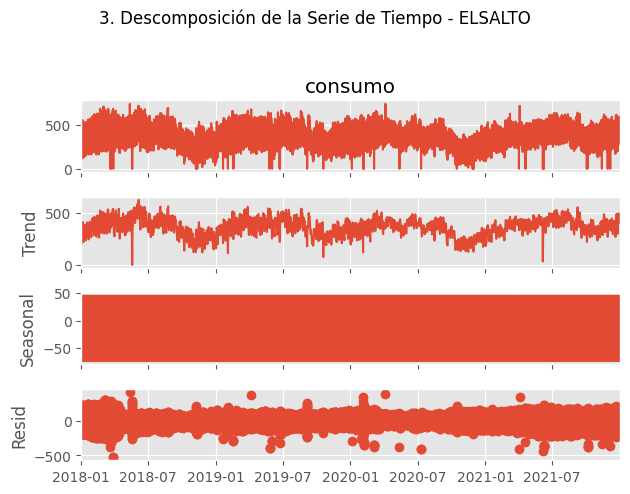

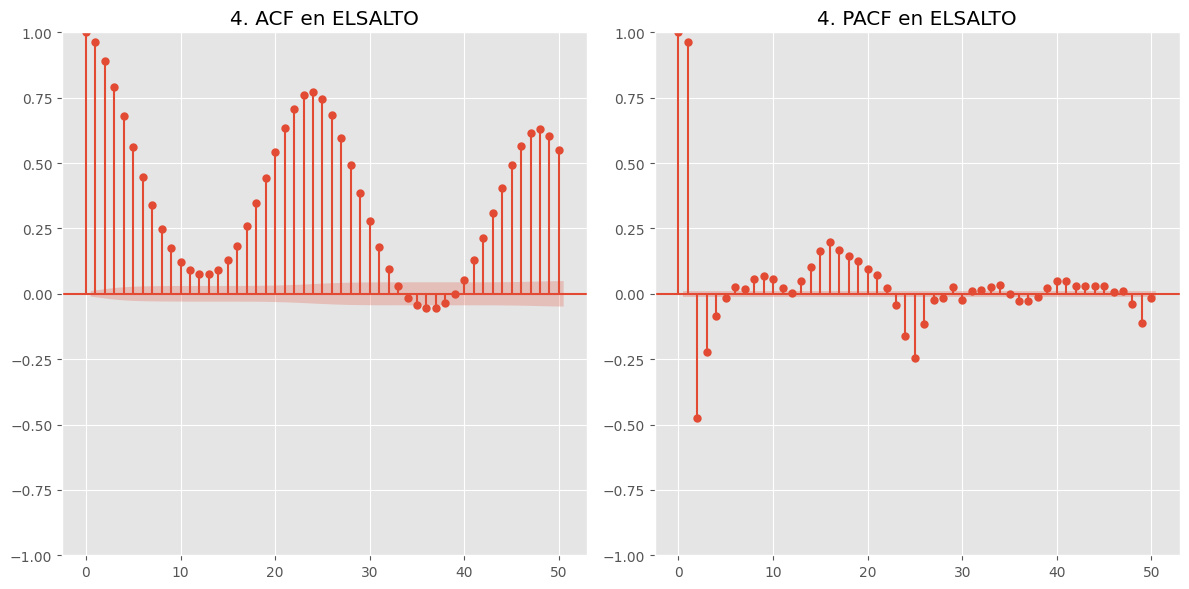


--- Analizando Subestación: BUIN ---


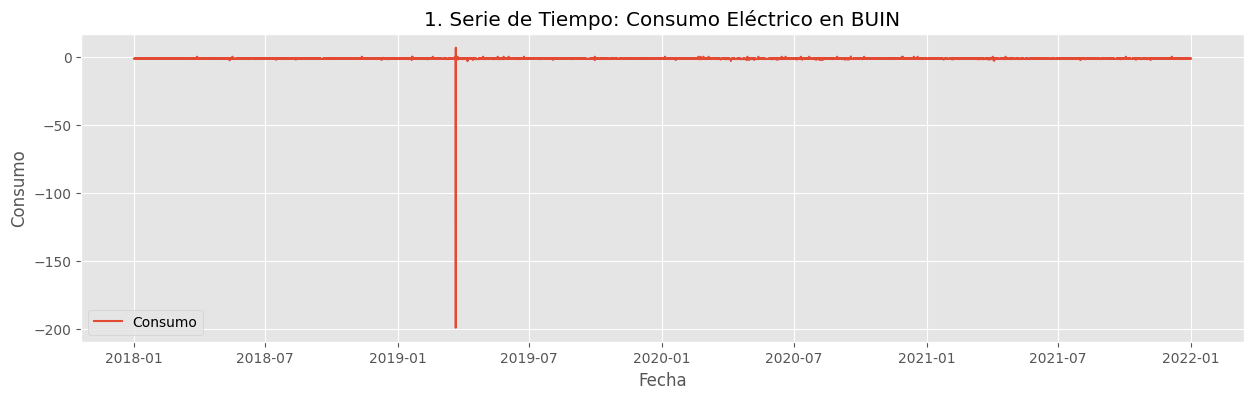

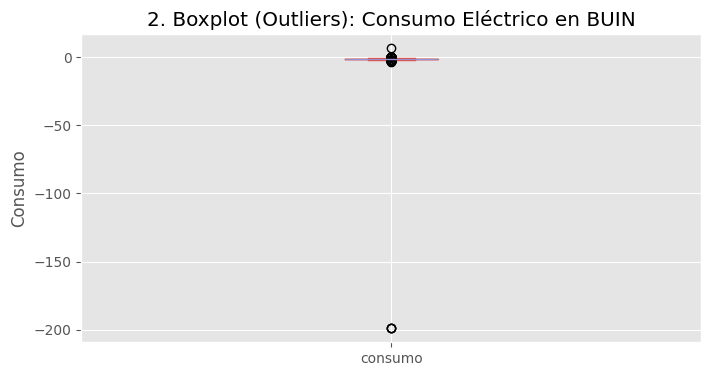

<Figure size 1500x800 with 0 Axes>

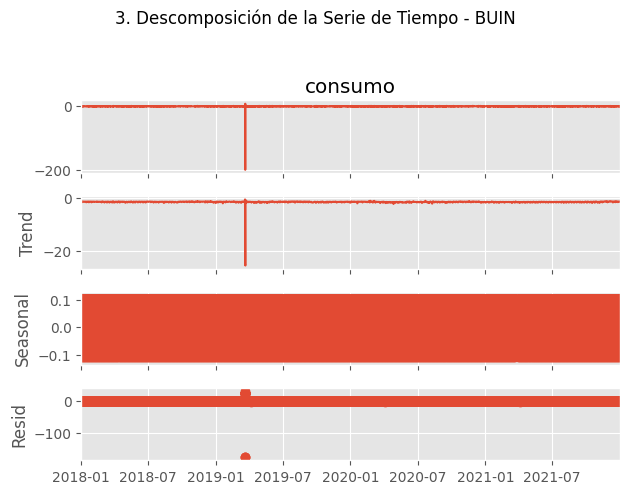

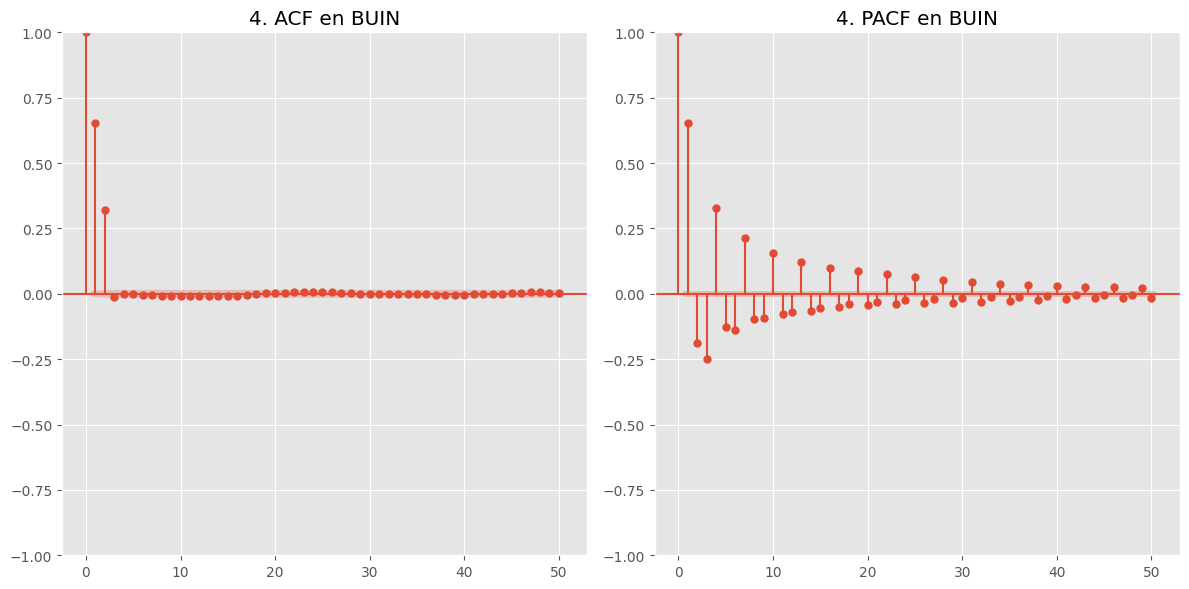


--- Analizando Subestación: LOSALME ---


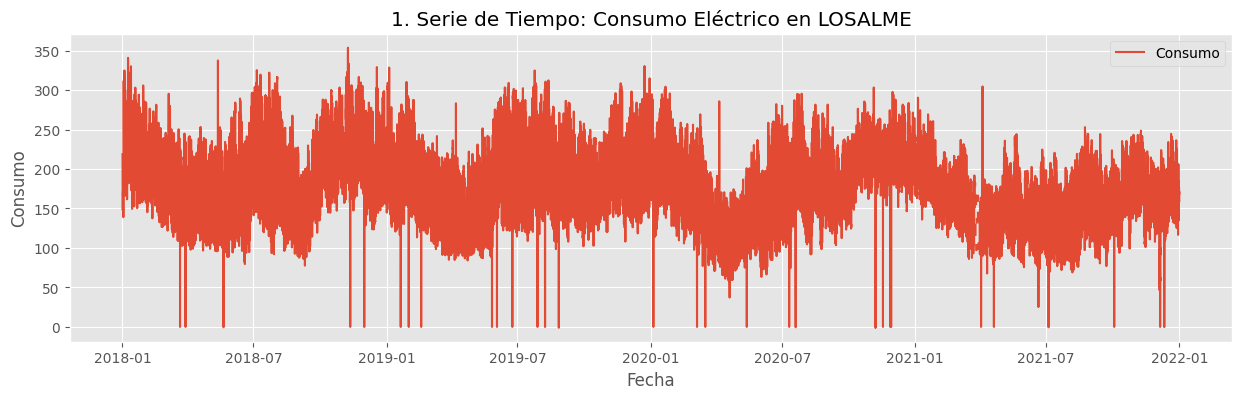

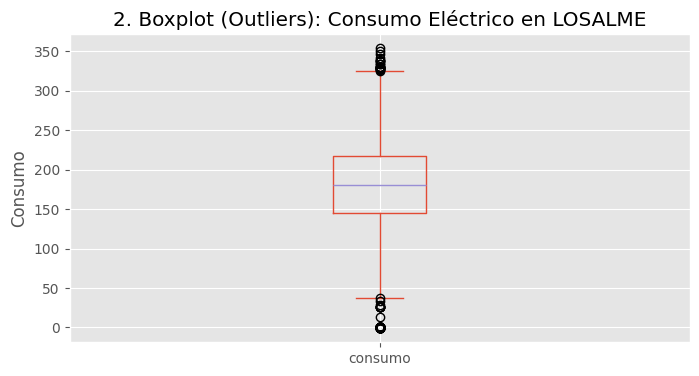

<Figure size 1500x800 with 0 Axes>

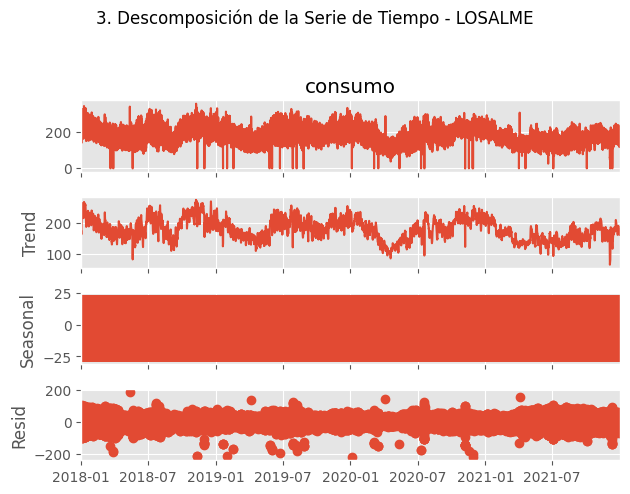

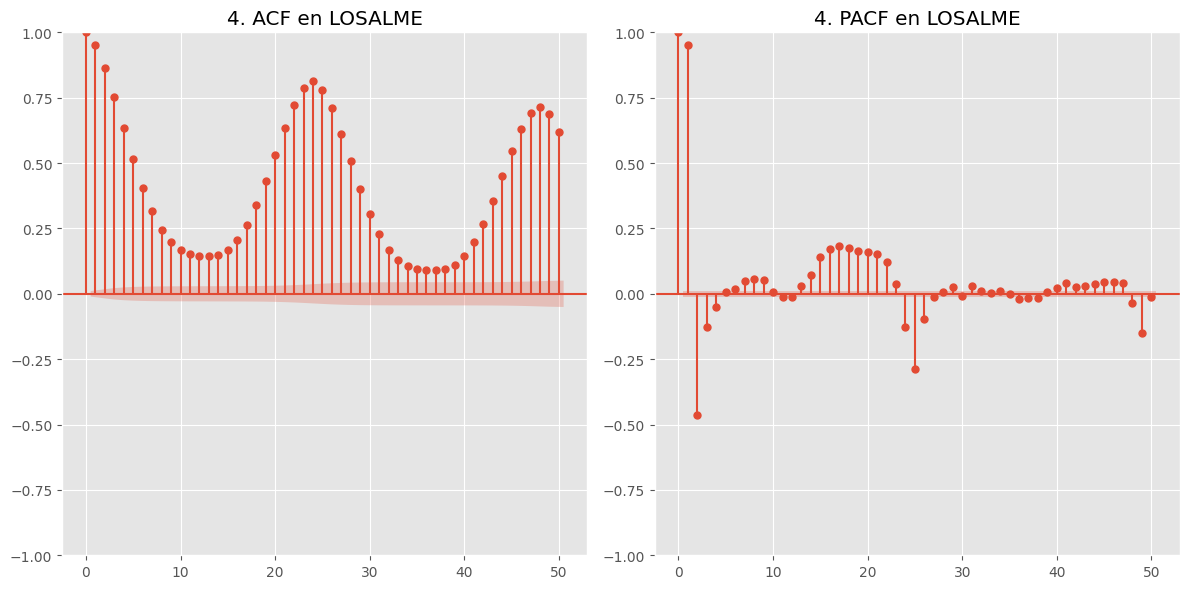

In [73]:
# Análisis de Datos Diferenciado por Subestación

for sub in subestaciones_analisis:
    print(f"\n--- Analizando Subestación: {sub} ---")
    data_sub = df_train_full[df_train_full['subestacion'] == sub]['consumo'].asfreq('H')
    
    # 1. Gráfico de Series de Tiempo
    plt.figure(figsize=(15, 4))
    plt.plot(data_sub, label='Consumo')
    plt.title(f'1. Serie de Tiempo: Consumo Eléctrico en {sub}')
    plt.xlabel('Fecha')
    plt.ylabel('Consumo')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Gráfico de Outliers (Boxplot)
    plt.figure(figsize=(8, 4))
    data_sub.plot(kind='box')
    plt.title(f'2. Boxplot (Outliers): Consumo Eléctrico en {sub}')
    plt.ylabel('Consumo')
    plt.grid(True)
    plt.show()

    # 3. Gráfico de Variaciones (Descomposición de la Serie de Tiempo)

    if len(data_sub) >= 48:
        try:
            decomposition = seasonal_decompose(data_sub.dropna(), model='additive', period=24)
            plt.figure(figsize=(15, 8))
            decomposition.plot()
            plt.suptitle(f'3. Descomposición de la Serie de Tiempo - {sub}', y=1.02)
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            plt.show()
        except Exception as e:
            print(f"Error al descomponer la serie para {sub}: {e}")
            plt.close('all')
    else:
        print(f"Datos insuficientes para la descomposición ({len(data_sub)} puntos).")


    # 4. Autocorrelación y Correlaciones Parciales
    if len(data_sub.dropna()) > 50:
        plt.figure(figsize=(12, 6))
        # Gráfico de Autocorrelación (ACF)
        ax1 = plt.subplot(121)
        plot_acf(data_sub.dropna(), lags=50, ax=ax1, title=f'4. ACF en {sub}')

        # Gráfico de Autocorrelación Parcial (PACF)
        ax2 = plt.subplot(122)
        plot_pacf(data_sub.dropna(), lags=50, ax=ax2, title=f'4. PACF en {sub}')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Datos insuficientes para ACF/PACF ({len(data_sub.dropna())} puntos).")

In [74]:
# Preparación Global de Datos y Bucles de Modelado


def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def build_model(model_type, time_step):

    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=False, input_shape=(time_step, 1)))
    else:
        raise ValueError("model_type debe ser 'LSTM' o 'GRU'")
        
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def calculate_metrics(y_true, y_pred):
    """Calcula RMSE, MAE, R2."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# --- 2. Preparación y Bucle de Entrenamiento ---

time_step = 24
all_metrics = []
all_predictions = {}

subestaciones_modelado = df_train_full['subestacion'].unique() 

for sub in subestaciones_modelado:
    print(f"\n--- Modelando Subestación: {sub} ---")
    

    data_train = df_train_full[df_train_full['subestacion'] == sub]['consumo'].asfreq('H').dropna()
    data_test = df_test_full[df_test_full['subestacion'] == sub]['consumo'].asfreq('H').dropna()
    
    if len(data_train) < time_step * 2 or len(data_test) < time_step:
        print(f"Datos insuficientes para modelar {sub}. Saltando.")
        continue


    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(data_train.values.reshape(-1, 1))
    test_scaled = scaler.transform(data_test.values.reshape(-1, 1))
    
    X_train, y_train = create_dataset(train_scaled, time_step)
    X_test, y_test = create_dataset(test_scaled, time_step)
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    y_test_real = data_test.values[time_step:] # El valor real para métricas
    test_index = data_test.index[time_step:]

    # ----------------------------------------
    # Entrenar y Evaluar LSTM
    # ----------------------------------------
    model_lstm = build_model('LSTM', time_step)
    model_lstm.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)
    
    predictions_lstm_scaled = model_lstm.predict(X_test)
    N = X_test.shape[0]
    predictions_lstm = scaler.inverse_transform(predictions_lstm_scaled.reshape(N, -1)[:, 0].reshape(-1, 1)).flatten()
    
    rmse_l, mae_l, r2_l = calculate_metrics(y_test_real, predictions_lstm)
    
    all_metrics.append({
        'Subestacion': sub, 'Modelo': 'LSTM', 'RMSE': rmse_l, 'MAE': mae_l, 'R2': r2_l
    })
    all_predictions[f'{sub}_LSTM'] = (test_index, y_test_real, predictions_lstm)

    # ----------------------------------------
    # Entrenar y Evaluar GRU
    # ----------------------------------------
    model_gru = build_model('GRU', time_step)
    model_gru.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)
    
    predictions_gru_scaled = model_gru.predict(X_test)
    predictions_gru = scaler.inverse_transform(predictions_gru_scaled.reshape(N, -1)[:, 0].reshape(-1, 1)).flatten()
    
    rmse_g, mae_g, r2_g = calculate_metrics(y_test_real, predictions_gru)
    
    all_metrics.append({
        'Subestacion': sub, 'Modelo': 'GRU', 'RMSE': rmse_g, 'MAE': mae_g, 'R2': r2_g
    })
    all_predictions[f'{sub}_GRU'] = (test_index, y_test_real, predictions_gru)
    
    print(f"  LSTM: RMSE={rmse_l:.2f}, R2={r2_l:.3f} | GRU: RMSE={rmse_g:.2f}, R2={r2_g:.3f}")

df_metrics = pd.DataFrame(all_metrics)


--- Modelando Subestación: AJAHUEL ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  LSTM: RMSE=20.17, R2=0.954 | GRU: RMSE=18.84, R2=0.960

--- Modelando Subestación: FLORIDA ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  LSTM: RMSE=6.51, R2=0.953 | GRU: RMSE=6.44, R2=0.955

--- Modelando Subestación: CHENA ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
  LSTM: RMSE=19.47, R2=0.967 | GRU: RMSE=17.84, R2=0.972

--- Modelando Subestación: CNAVIA ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  LSTM: RMSE=39.08, R2=0.972 | GRU: RMSE=37.06, R2=0.975

--- Modelando Subestación: ELSALTO ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  LSTM: RMSE=41.08, R2=0.974 | GRU: RMSE=41.59, R2=0.973

--- Modelando Subestación: BUIN ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 


--- Métricas Agregadas por Subestación y Modelo ---
5 Mejores Resultados (por R2):
Subestacion Modelo      RMSE       MAE       R2
     CNAVIA    GRU 37.057445 22.169294 0.974674
    ELSALTO   LSTM 41.078174 22.398200 0.973600
    ELSALTO    GRU 41.592088 22.203824 0.972935
      CHENA    GRU 17.844480 10.095748 0.972019
     CNAVIA   LSTM 39.077663 24.230778 0.971838

RMSE Promedio Global:
Modelo
GRU     19.478639
LSTM    20.204825

Generando gráficos de predicción para las primeras 7 subestaciones...


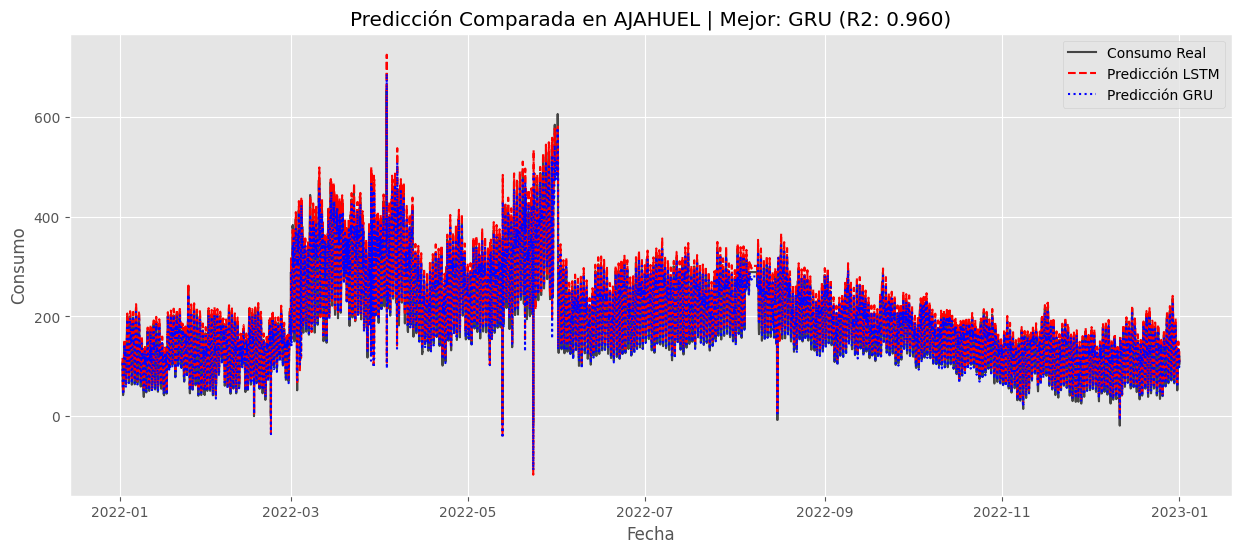

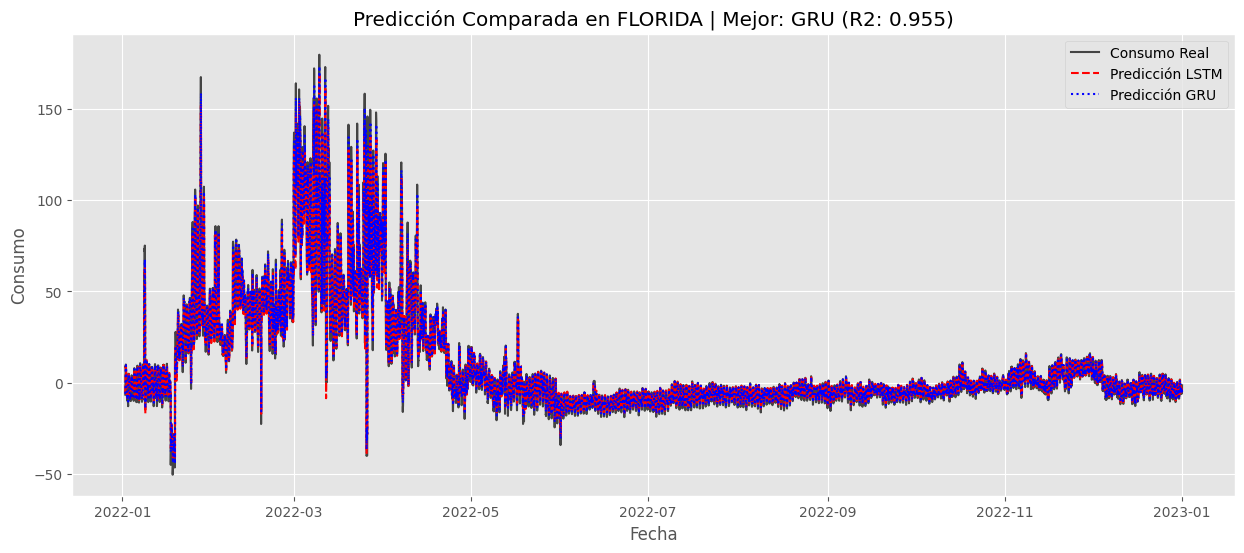

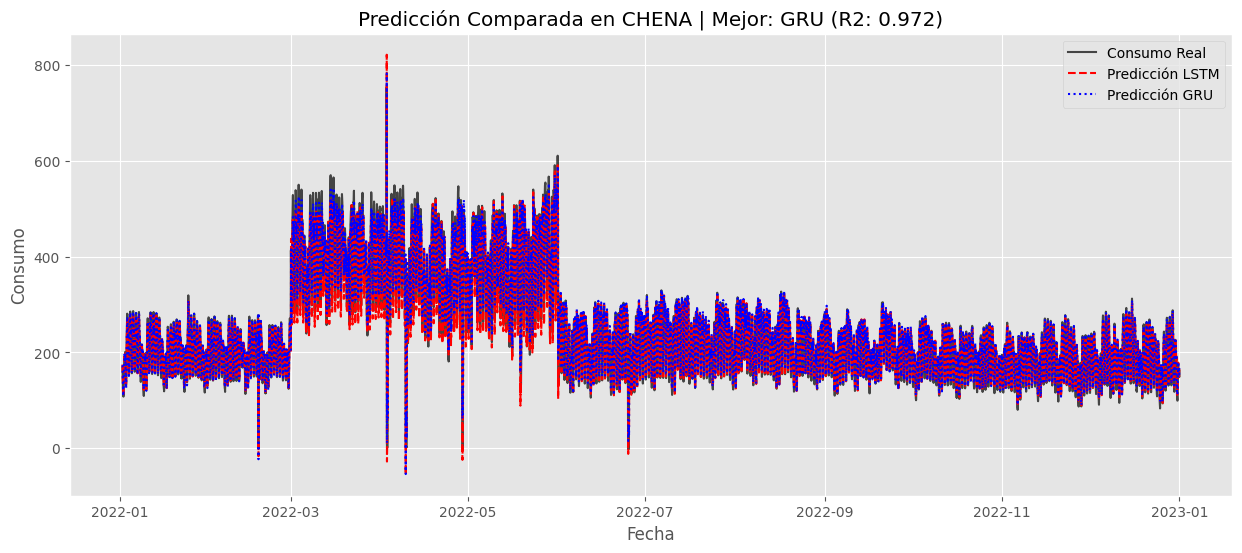

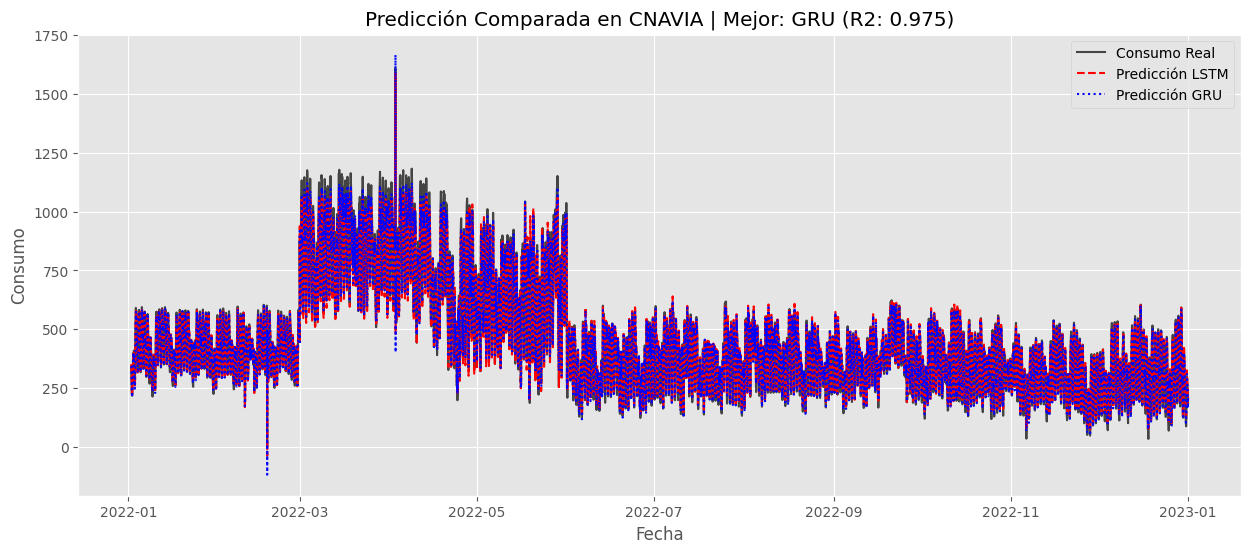

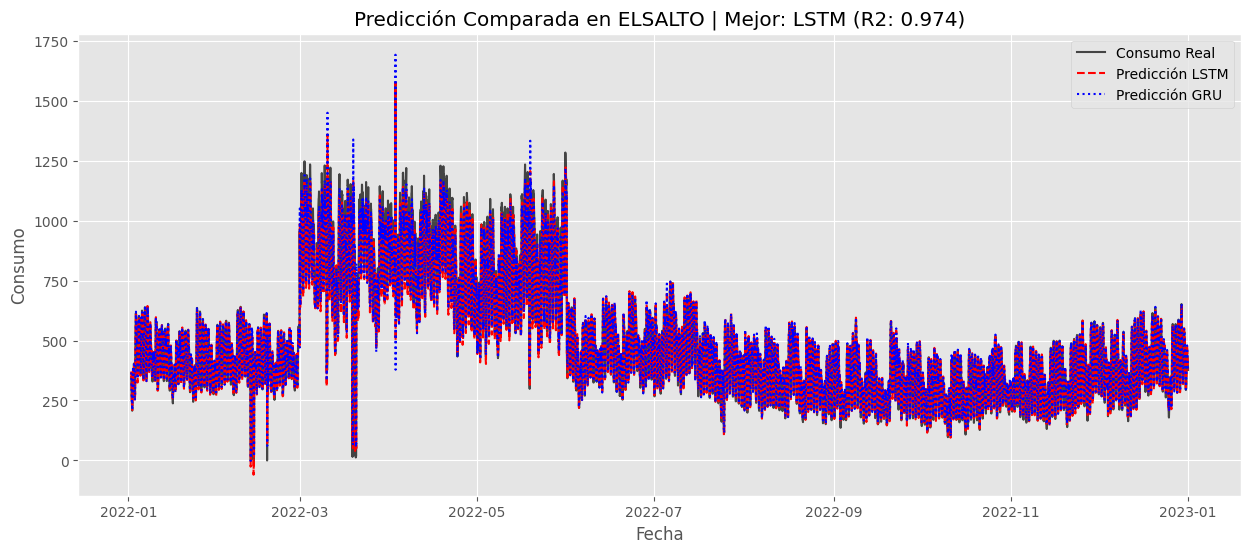

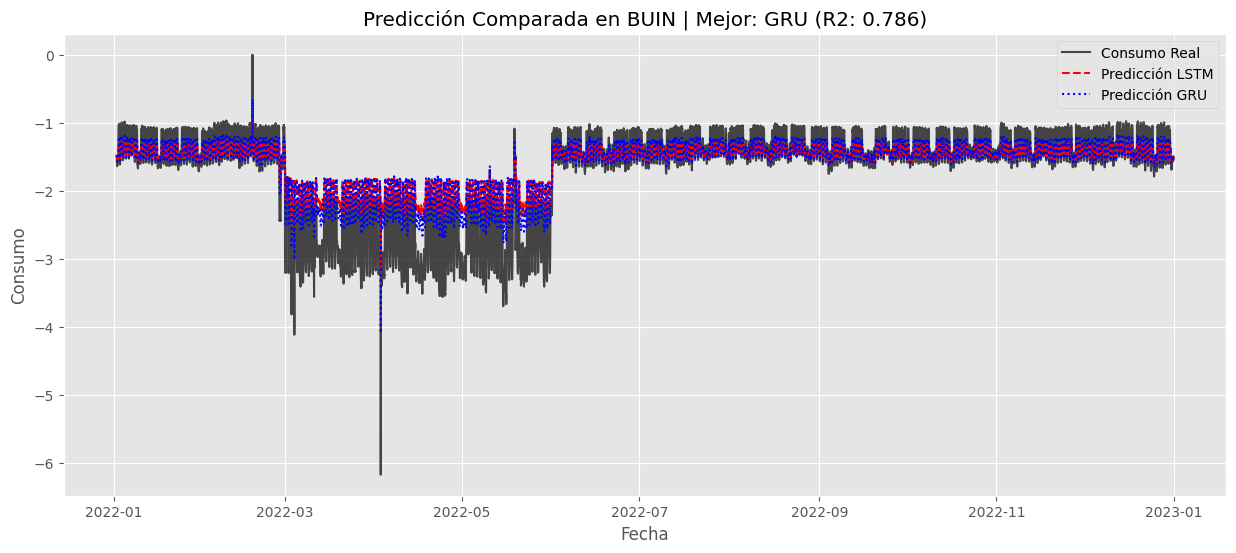

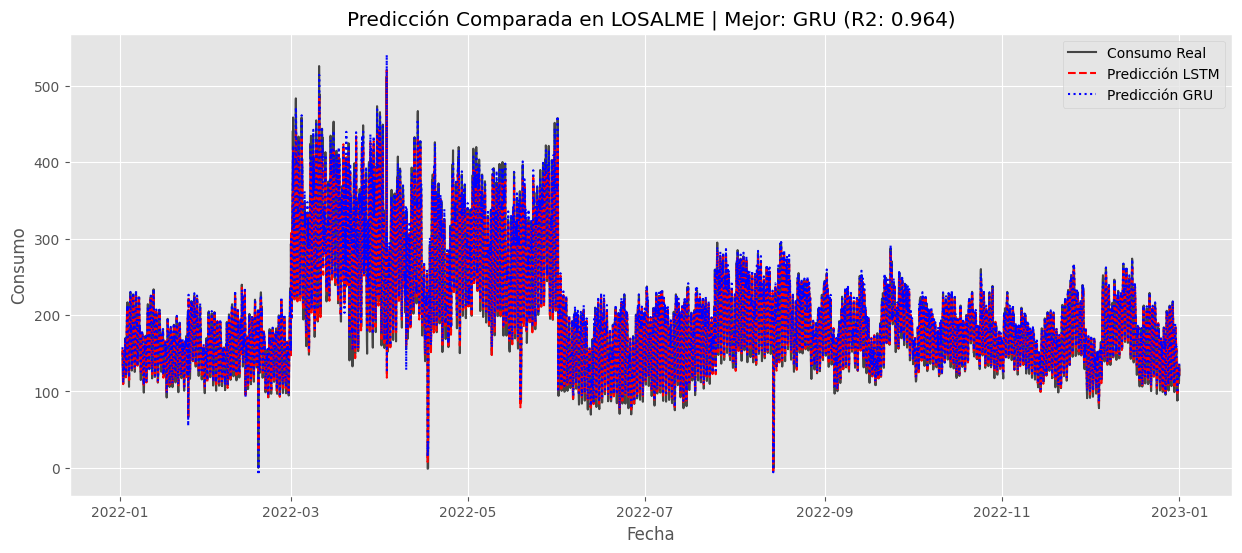

In [75]:
# Resultados y Gráficos Finales

print("\n--- Métricas Agregadas por Subestación y Modelo ---")

df_metrics_sorted = df_metrics.sort_values(by='R2', ascending=False)
print("5 Mejores Resultados (por R2):")
print(df_metrics_sorted.head().to_string(index=False))

print("\nRMSE Promedio Global:")
print(df_metrics.groupby('Modelo')['RMSE'].mean().to_string())

# Generar gráficos de predicción diferenciados por subestación (limitando a las primeras 3)

NUM_PLOTS_TO_SHOW = 7 
subestaciones_plot = subestaciones_modelado[:NUM_PLOTS_TO_SHOW]
print(f"\nGenerando gráficos de predicción para las primeras {NUM_PLOTS_TO_SHOW} subestaciones...")

for sub in subestaciones_plot:
    if f'{sub}_LSTM' in all_predictions:
        test_index, y_real, y_pred_lstm = all_predictions[f'{sub}_LSTM']
        _, _, y_pred_gru = all_predictions[f'{sub}_GRU']
        
        plt.figure(figsize=(15, 6))
        plt.plot(test_index, y_real, label='Consumo Real', color='black', alpha=0.7)
        plt.plot(test_index, y_pred_lstm, label='Predicción LSTM', color='red', linestyle='--')
        plt.plot(test_index, y_pred_gru, label='Predicción GRU', color='blue', linestyle=':')
        
    
        best_model_sub = df_metrics[(df_metrics['Subestacion'] == sub)].sort_values(by='RMSE').iloc[0]
        
        plt.title(f'Predicción Comparada en {sub} | Mejor: {best_model_sub["Modelo"]} (R2: {best_model_sub["R2"]:.3f})')
        plt.xlabel('Fecha')
        plt.ylabel('Consumo')
        plt.legend()
        plt.grid(True)
        plt.show()